<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
Meep Tutorial: Coupler
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>January, 2025</font></center>

***

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import meep as mp

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'

Using MPI version 3.1, 1 processes


In [2]:
res = 25  # pixels/μm
three_d = False  # 3d calculation?
d = 0.06  # branch separation: 0.06/100%, 0.13/50%, 0.30/0%

gdsII_file = "coupler.gds"
CELL_LAYER = 0
PORT1_LAYER = 1
PORT2_LAYER = 2
PORT3_LAYER = 3
PORT4_LAYER = 4
SOURCE_LAYER = 5
UPPER_BRANCH_LAYER = 31
LOWER_BRANCH_LAYER = 32
default_d = 0.3

t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1
cell_thickness = dpml + t_oxide + t_Si + t_air + dpml

oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1 / lcen
df = 0.2 * fcen

cell_zmax = 0.5 * cell_thickness if three_d else 0
cell_zmin = -0.5 * cell_thickness if three_d else 0
si_zmax = 0.5 * t_Si if three_d else 10
si_zmin = -0.5 * t_Si if three_d else -10

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
upper_branch = mp.get_GDSII_prisms(
    silicon, gdsII_file, UPPER_BRANCH_LAYER, si_zmin, si_zmax
)
lower_branch = mp.get_GDSII_prisms(
    silicon, gdsII_file, LOWER_BRANCH_LAYER, si_zmin, si_zmax
)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)
p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, si_zmin, si_zmax)
p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, si_zmin, si_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

# displace upper and lower branches of coupler (as well as source and flux regions)
if d != default_d:
    delta_y = 0.5 * (d - default_d)
    delta = mp.Vector3(y=delta_y)
    p1.center += delta
    p2.center -= delta
    p3.center += delta
    p4.center -= delta
    src_vol.center += delta
    cell.size += 2 * delta
    for nn in range(len(lower_branch)):
        lower_branch[nn].center -= delta
        for nv in range(len(lower_branch[nn].vertices)):
            lower_branch[nn].vertices[nv] -= delta
    for nn in range(len(upper_branch)):
        upper_branch[nn].center += delta
        for nv in range(len(upper_branch[nn].vertices)):
            upper_branch[nn].vertices[nv] += delta

geometry = upper_branch + lower_branch

if three_d:
    oxide_center = mp.Vector3(z=-0.5 * t_oxide)
    oxide_size = mp.Vector3(cell.size.x, cell.size.y, t_oxide)
    oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
    geometry = geometry + oxide_layer

sources = [
    mp.EigenModeSource(
        src=mp.GaussianSource(fcen, fwidth=df),
        size=src_vol.size,
        center=src_vol.center,
        eig_band=1,
        eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
    )
]

sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p4))

sim.run(until_after_sources=100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.004479 s
Working in 2D dimensions.
Computational cell is 34.4 x 7.76 x 0 with resolution 25
     prism, center = (-9.09425,1.29149,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 174 vertices:
          (-4,0.03,-10)
          (-4.108,0.031,-10)
          (-4.215,0.032,-10)
          (-4.322,0.035,-10)
          (-4.429,0.04,-10)
          (-4.535,0.045,-10)
          (-4.641,0.051,-10)
          (-4.747,0.059,-10)
          (-4.852,0.067,-10)
          (-5.062,0.087,-10)
          (-5.167,0.099,-10)
          (-5.271,0.111,-10)
          (-5.479,0.139,-10)
          (-5.582,0.154,-10)
          (-5.685,0.17,-10)
          (-5.788,0.187,-10)
          (-5.891,0.205,-10)
          (-5.993,0.223,-10)
          (-6.095,0.242,-10)
          (-6.197,0.262,-10)
          (-6.299,0.283,-10)
          (-6.4,0.304,-10)
          (-6.501,0.326,-10)
          (-6.703,0.372,-10)
          (-6.803,0.395,-10)
  

FloatProgress(value=0.0, description='0% done ', max=177.5)

run 0 finished at t = 177.5 (8875 timesteps)


In [3]:
# S parameters
p1_coeff = sim.get_eigenmode_coefficients(
    mode1, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 0]
p2_coeff = sim.get_eigenmode_coefficients(
    mode2, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 1]
p3_coeff = sim.get_eigenmode_coefficients(
    mode3, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 0]
p4_coeff = sim.get_eigenmode_coefficients(
    mode4, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 0]

# transmittance
p2_trans = abs(p2_coeff) ** 2 / abs(p1_coeff) ** 2
p3_trans = abs(p3_coeff) ** 2 / abs(p1_coeff) ** 2
p4_trans = abs(p4_coeff) ** 2 / abs(p1_coeff) ** 2

print("trans:, {:.2f}, {:.6f}, {:.6f}, {:.6f}".format(d, p2_trans, p3_trans, p4_trans))

MPB solved for frequency_1(2.2349,0,0) = 0.68533 after 11 iters
MPB solved for frequency_1(2.09126,0,0) = 0.645199 after 7 iters
MPB solved for frequency_1(2.09113,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.09113,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091129,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.68533 after 11 iters
MPB solved for frequency_1(2.09126,0,0) = 0.645199 after 7 iters
MPB solved for frequency_1(2.09113,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.09113,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091129,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.68533 after 11 iters
MPB solved for frequency_1(2.09126,0,0) = 0.645199 after 7 iters
MPB solved for frequency_1(2.09113,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.09113,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091129,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) =

In [4]:
sim.reset_meep()

sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(fcen, fwidth=df),
        size=src_vol.size,
        center=src_vol.center,
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
    )
]

sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

sim.run(
    until=400
)  # arbitrary long run time to ensure that fields have reached steady state

eps_data = sim.get_epsilon()
ez_data = np.real(sim.get_efield_z())

-----------
Initializing structure...
time for choose_chunkdivision = 0.004331 s
Working in 2D dimensions.
Computational cell is 34.4 x 7.76 x 0 with resolution 25
     prism, center = (-9.09425,1.29149,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 174 vertices:
          (-4,0.03,-10)
          (-4.108,0.031,-10)
          (-4.215,0.032,-10)
          (-4.322,0.035,-10)
          (-4.429,0.04,-10)
          (-4.535,0.045,-10)
          (-4.641,0.051,-10)
          (-4.747,0.059,-10)
          (-4.852,0.067,-10)
          (-5.062,0.087,-10)
          (-5.167,0.099,-10)
          (-5.271,0.111,-10)
          (-5.479,0.139,-10)
          (-5.582,0.154,-10)
          (-5.685,0.17,-10)
          (-5.788,0.187,-10)
          (-5.891,0.205,-10)
          (-5.993,0.223,-10)
          (-6.095,0.242,-10)
          (-6.197,0.262,-10)
          (-6.299,0.283,-10)
          (-6.4,0.304,-10)
          (-6.501,0.326,-10)
          (-6.703,0.372,-10)
          (-6.803,0.395,-10)
  

FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 188.36/400.0 = 47.1% done in 4.0s, 4.5s to go
on time step 9421 (time=188.42), 0.000424586 s/step
Meep progress: 379.58/400.0 = 94.9% done in 8.0s, 0.4s to go
on time step 18983 (time=379.66), 0.000418343 s/step
run 0 finished at t = 400.0 (20000 timesteps)


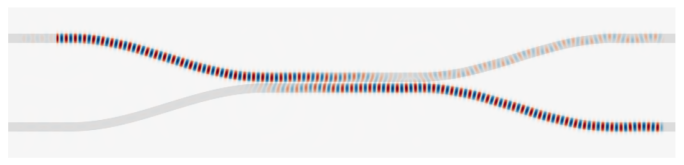

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
ax.imshow(
    np.flipud(np.transpose(ez_data)),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.95,
)
ax.axis("off")

plt.show()